In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, evidence_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.helpers import n_clust_obs_f_f, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_calibration_curve

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer
from bayesflow.losses import log_loss

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

## Try out performance of simple softmax network

In [3]:
# from src.python.networks import InvariantNetwork

# class HierarchicalInvariantNetwork(tf.keras.Model):
#     """
#     Implements a network that is able to summarize hierarchical data.
#     """
    
#     def __init__(self, meta):
#         """
#         Creates a hierarchical Network consisting of two stacked invariant modules.
#         ----------
        
#         Arguments:
#         model_settings : dict -- hyperparameter settings for the hierarchical network
#         """
        
#         super(HierarchicalInvariantNetwork, self).__init__()
        
#         self.inv_4d = InvariantNetwork(meta['level_1'])
#         self.inv_3d = InvariantNetwork(meta['level_2'])
        
#         self.model_probs_layer = tf.keras.layers.Dense(2, activation="softmax")
        
#     def call(self, x):
#         """
#         Transforms the 4-dimensional input into learned summary statistics.
#         ----------
        
#         Arguments:
#         x : tf.Tensor of shape (batch_size, n_clusters, n_obs, n_variables) -- simulated data
#         --------
        
#         Returns:
#         out : tf.Tensor of shape (batch_size, (dense_inv_post_pooling_args on level_2) + 2) -- the learned summary statistics
#         """

#         # Pass through invariant networks
#         out = self.inv_4d(x)
#         out = self.inv_3d(out)

#         # Extract number of clusters and observations into a repeated vector and concatenate with network output
#         n_clust = int(x.shape[-3])
#         n_clust_rep = tf.math.sqrt(n_clust * tf.ones((x.shape[0], 1)))
#         out = tf.concat((out, n_clust_rep), axis=-1)

#         n_obs = int(x.shape[-2])
#         n_obs_rep = tf.math.sqrt(n_obs * tf.ones((x.shape[0], 1)))
#         out = tf.concat((out, n_obs_rep), axis=-1)

#         out = self.model_probs_layer(out)

#         return out

# Set up networks

In [4]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net = EvidentialNetwork(evidence_meta_validation)

amortizer = MultiModelAmortizer(evidence_net, summary_net)
#amortizer = MultiModelAmortizer(summary_net) # for softmax network

simulator = MainSimulator(HierarchicalSdtMptSimulator())

In [5]:
# Cosine Decay with Restarts
#initial_lr = 0.0005
initial_lr = 0.00075 # higher learning rate to prevent stagnation in local minimum
first_decay_steps = 1000
t_mul = 2
m_mul = 0.9
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
trial_folder = 'checkpoints'
checkpoint_path = os.path.join(os.getcwd(), trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam, lr_schedule_restart),
    #checkpoint_path=checkpoint_path, # TEMPORARY
    skip_checks=True,
    )

# Sample size
n_clusters = 100
n_obs = 50

# Train

In [6]:
losses = trainer.train_online(
    epochs=10, iterations_per_epoch=1000, batch_size=32, 
    n_obs=partial(n_clust_obs_f_f, n_clusters, n_obs), n_vars=2
    )

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Validate

In [7]:
# Simulate data
n_data_sets = 5000

m_val, _, x_val = simulator(batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2)
val_data = {'X' : x_val, 'm' : m_val}

ECE = 0.069


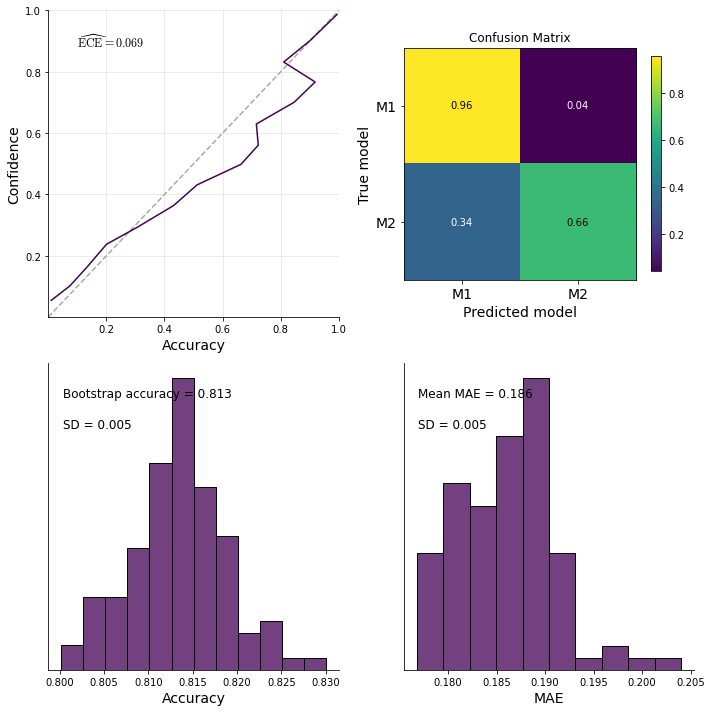

In [8]:
perf_tester(evidence_net, summary_net, val_data, n_cal_bins=15)

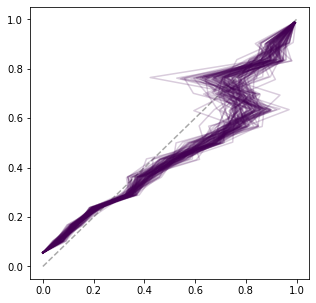

In [42]:
from sklearn.calibration import calibration_curve
from src.python.settings import plotting_settings

import seaborn as sns

n_bootstrap = 100
n_cal_bins = 15

# Get predictions
m_soft = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(val_data['X'], 20)], axis=0).numpy()
m_hard = (m_soft > 0.5).astype(np.int32)
m_true = val_data['m'][:, 1]

# Prepare arrays
probs_true = np.zeros((n_bootstrap, n_cal_bins))
probs_pred = np.zeros((n_bootstrap, n_cal_bins))
cal_errors = np.zeros(n_bootstrap)

# Prepare plot
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot((0,1), (0,1), '--', color='darkgrey')

# Bootstrap
for b in range(n_bootstrap):
    b_idx = np.random.choice(np.arange(n_data_sets), size=n_data_sets, replace=True)
    probs_true[b, :], probs_pred[b, :] = calibration_curve(m_true[b_idx], m_soft[b_idx], n_bins=15)
    cal_errors[b] = np.mean(np.abs(probs_true[b, :] - probs_pred[b, :]))

    ax.plot(probs_true[b, :], probs_pred[b, :], color=plotting_settings['colors_discrete'][0], alpha=0.2)

# Finish plot


# ax.set_xlim([0, 1])
# ax.set_ylim([0, 1])
# ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
# ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
# ax.set_xlabel('Accuracy',  fontsize=plotting_settings['fontsize_labels'])
# ax.set_ylabel('Confidence',  fontsize=plotting_settings['fontsize_labels'])
# ax.grid(alpha=.3)
# ax.text(0.1, 0.9, r'$\widehat{{\mathrm{{ECE}}}} = {0:.3f}$'.format(np.mean(cal_errors)),
#         horizontalalignment='left', verticalalignment='center',
#         transform=ax.transAxes, size=12)
# sns.despine(ax=ax)

In [35]:
probs_true.shape

(5000, 15)

ECE = 0.074
ECE = 0.081
ECE = 0.080
ECE = 0.085
ECE = 0.067
ECE = 0.080
ECE = 0.077
ECE = 0.079
ECE = 0.084
ECE = 0.069


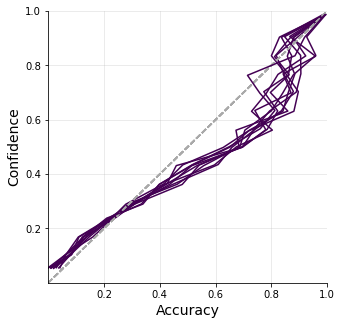

In [41]:
# Plot bootstrapped calibration curves

fig, ax = plt.subplots(figsize=(5,5))

for i in range(10):
    m_val, _, x_val = simulator(batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2)
    val_data = {'X' : x_val, 'm' : m_val}

    # Compute model predictions in chunks so GPU memory does not blow-up
    m_soft = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(val_data['X'], 20)], axis=0).numpy()
    m_hard = (m_soft > 0.5).astype(np.int32)
    m_true = val_data['m'][:, 1]
    plot_calibration_curve(m_true, m_soft, n_bins=15, ax=ax, show_ece=False)

In [ ]:
# Hack to work only with summary net

In [ ]:
# from src.python.visualization import plot_confusion_matrix, plot_bootstrap_accuracy, plot_bootstrap_mae

# def perf_tester_single(summary_net, val_data, n_bootstrap=100, n_cal_bins=15, pub_style=False, save=False):
#     """Helper function to test the performance of the model."""
    
#     # Compute model predictions in chunks so GPU memory does not blow-up
#     m_soft = tf.concat([summary_net(x_chunk)[:, 1] for x_chunk in tf.split(val_data['X'], 20)], axis=0).numpy()
#     m_hard = (m_soft > 0.5).astype(np.int32)
#     m_true = val_data['m'][:, 1]
    
#     if pub_style == False:
#         # Prepare figures
#         fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
        
#         # Plot stuff
#         plot_calibration_curve(m_true, m_soft, n_cal_bins, axarr[0, 0])
#         plot_confusion_matrix(m_true, m_hard, ['M1', 'M2'], axarr[0, 1])
#         plot_bootstrap_accuracy(m_true, m_hard, n_bootstrap, axarr[1, 0])
#         plot_bootstrap_mae(m_true, m_hard, n_bootstrap, axarr[1, 1])
#         fig.tight_layout()

#     elif pub_style == True:
#         fig, ax = plt.subplots(figsize=(5,5))
#         plot_calibration_curve(m_true, m_soft, n_cal_bins, ax)
#         if save == True:
#             fig.savefig('calibration_fixed_sizes.png', dpi=300, bbox_inches='tight')

# perf_tester_single(summary_net, val_data, n_cal_bins=15)